# Proyecto II: De palabras a Vectores

En este proyecto vamos a implementar uno de los sistemas más utilizados par aconvertir palabras a vectores **word2vec**. En este proyecto la idea es que ustedes creén una base de datos de texto, la cúal utilizarán para entrenar la códigficación de estás palabras, y a partir de allí implementar ciertos sistemas. Par afacilitar el trabajo, en este notebook pueden encontrar unas funciones que fueron extraidas de esté [link](https://towardsdatascience.com/a-word2vec-implementation-using-numpy-and-python-d256cf0e5f28), y adaptadas para trabajar con el lenguaje español. Sientanse libres de utilizar estas funciones o de adaptarlas asu gusto. Las funciones toman como entrada un texto en formato plano, y al finalizar entregan el vector de palabras de contexto y el vector target que puede ser utilizado para entrenar el modelo word2vec. Los datos de entrenamiento se entregan en una lista que contiene el vector de salida (codificación one hot de una palabra) y el vector que contiene la suma de los vectores hot encoded de las palabras de contexto. Para escoger el tamaño de la palabra de contexto deben modificar el parámetro $C$.

Para este proyecto necesitan realizar lo siguiente:

1. Obtengan un corpus de texto plano en Español, lo suficientemente largo, que contenga información sobre diferentes países. Este texto lo pueden extraer de wikipedia.
2. Con la información de este corpus entrenen un modelo word2vec, aquí debe seleccionar un valor $N$ que representa la longitud del vector que representará las palabras. Este modelo es una red neuronal con una sola capa oculta de $N$ neuronas.
3. Una vez tengan el modelo identifiquen la relación entre algunos países (no todos) de su corpus y sus capitales.
4. Mediante esta relación encuentren las capitales de los demás países que incluyeron en el corpus. Para esto deben realizar una búsqueda de vectores cercanos a un punto en el espacio $\mathbb{R}^{\text{N}}$. Esta búsqueda la pueden realizar con *Locally Sensitive Hashing*.
4. Realice una visualización en 2D o 3D de los vectores correspondientes a los países y sus capitales. Indicando los que usarón de referencia para encontrar la relación entre país y capital, y aquellos para los cuales no utilizarón esa relación.
5. Seleccione 5 Palabras y para ellas calcule las 10 palabras más parecidas (sinonimos) en orden de similitud.
6. Construya un nuevo corpus, más pequeño, sobre un tema cualquiera. Para este corpus necesita la versión en Español y en Ingles de los textos. Una vez más pueden utilizar Wikipedia para esto. 
7. Obtenga las representaciones en vectores par alas palabras en Español y en Ingles.
8. De los datos obtenidos, escoga un conjunto $m$ de palabras en español, y las respectiva traducción en ingles (que se encuentren en el vocabulario que construyeron) y planteé el problema de transformacion $\mathcal{X}\mathbf{R} = \mathcal{Y}$. De tal forma que encuentren la matrix de "traducción" $\mathbf{R}$.
9. Realicé esta operación para varios valores de $m$.
10. Finalmente escoja algunas palabras en Español, apliqueles la transformación $\mathbf{R}$ y liste las 5 palabras más cercanas en $\mathcal{Y}$ a esta traducción.

Al finalizar los diferentes puntos del proyecto, contesten las isguientes preguntas:

1. ¿Qué problemas tuvierón a la hora de implementar el modelo word2vec?
2. ¿Cómo escogierón el parámetro $N$?
3. ¿Qué pueden decir de los resultados del modelo buscando la relación entre los países y las capitales?
4. ¿Qué tan bien funciona el modelo para los sinonimos?, ¿Cómo creen que se puede mejorar este modelo?
5. ¿Cómo afecta el parámetro $m$ el funcionamiento del modelo de traducción?
6. ¿Cómo mejorarian el modelo de traducción?
7. ¿Qué concluyen de este proyecto y de los resultados obtenidos?

Al finalizar deben entregar el notebook, con los archivos de soporte (los corpus) y demás elementos que consideren necesarios. Recuerde dar respuesta a las preguntas del notebook, y comentar cada parte del proceso. El proyecto se debe entregar a más tardar el **Domingo 29 de Marzo a las 12 de la noche**.


In [1]:
# Instalacion de libreria para algoritmo de clasificacion
!pip3 install lshashpy3

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Importacndo librerias necesarias

import re 
import numpy as np

# Matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Algoritmo de Locally Sensitive Hashing
import lshashpy3 as lshash

In [3]:
# Función para leer y procesar el archivo en texto plano.

def get_file_data(fname, stop_word_removal='no'):
    file_contents = []
    with open(fname,encoding="utf-8") as f:
        file_contents = f.read()
    text = []
    for val in file_contents.split('.'):
        val = re.sub(r'[,¡!¿?;-]+','.',val)
        val = re.sub(r'á','a',val)
        val = re.sub(r'é','e',val)
        val = re.sub(r'í','i',val)
        val = re.sub(r'ó','o',val)
        val = re.sub(r'ú','u',val)
        val = re.sub(r'Á','A',val)
        val = re.sub(r'É','E',val)
        val = re.sub(r'Í','I',val)
        val = re.sub(r'Ó','O',val)
        val = re.sub(r'Ú','U',val)
        val = re.sub(r'ñ','n',val)
        val = re.sub(r'Ñ','N',val)
        sent = re.findall("[A-Za-z]+", val)
        line = ''
        for words in sent:
            
            if stop_word_removal == 'yes': 
                if len(words) > 1 and words not in stop_words:
                    line = line + ' ' + words
            else:
                if len(words) > 1 :
                    line = line + ' ' + words
        text.append(line)
    return text

# Función para obtener un Vocabulario en función del texto procesado

def generate_dictinoary_data(text):
    word_to_index= dict()
    index_to_word = dict()
    corpus = []
    count = 0
    vocab_size = 0
    
    for row in text:
        for word in row.split():
            word = word.lower()
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

# Función para generar representaciones one hot de los vectores target y del corpus

def get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index):
    
    #Create an array of size = vocab_size filled with zeros
    trgt_word_vector = np.zeros(vocab_size)
    
    #Get the index of the target_word according to the dictionary word_to_index. 
    index_of_word_dictionary = word_to_index.get(target_word) 
    
    #Set the index to 1
    trgt_word_vector[index_of_word_dictionary] = 1
    
    #Repeat same steps for context_words but in a loop
    ctxt_word_vector = np.zeros(vocab_size)
    
    
    for word in context_words:
        index_of_word_dictionary = word_to_index.get(word) 
        ctxt_word_vector[index_of_word_dictionary] = 1
        
    return trgt_word_vector,ctxt_word_vector

# Función para generar los datos de entrenamiento para la red neuronal que representa el modelo word2vec

def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,sample=None):

    training_data =  []
    training_sample_words =  []
    for i,word in enumerate(corpus):

        index_target_word = i
        target_word = word
        context_words = []

        #when target word is the first word
        if i == 0:  

            # trgt_word_index:(0), ctxt_word_index:(1,2)
            context_words = [corpus[x] for x in range(i + 1 , window_size + 1)] 


        #when target word is the last word
        elif i == len(corpus)-1:

            # trgt_word_index:(9), ctxt_word_index:(8,7), length_of_corpus = 10
            context_words = [corpus[x] for x in range(length_of_corpus - 2 ,length_of_corpus -2 - window_size  , -1 )]

        #When target word is the middle word
        else:

            #Before the middle target word
            before_target_word_index = index_target_word - 1
            for x in range(before_target_word_index, before_target_word_index - window_size , -1):
                if x >=0:
                    context_words.extend([corpus[x]])

            #After the middle target word
            after_target_word_index = index_target_word + 1
            for x in range(after_target_word_index, after_target_word_index + window_size):
                if x < len(corpus):
                    context_words.extend([corpus[x]])


        trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index)
        training_data.append([trgt_word_vector,ctxt_word_vector])   
        
        if sample is not None:
            training_sample_words.append([target_word,context_words])   
        
    return training_data,training_sample_words

# Solucion

# Punto 2

In [4]:
# Ejecución del código

fname = 'paises' #Nombre del archivo
C = 2 # Número de palabras de contexto a la derecha y a la izquierda
text = get_file_data(fname, stop_word_removal='no')
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
training_data,training_sample_words = generate_training_data(corpus,C,vocab_size,word_to_index,length_of_corpus,sample=None)

In [5]:
# Matriz de entrada y de salida
X = np.array([x[1] for x in training_data])
Y = np.array([y[0] for y in training_data])

In [6]:
# Definiendo red neuronal
model = Sequential()  
model.add(Dense(100,input_shape=(vocab_size,), activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='CategoricalCrossentropy', optimizer='rmsprop', metrics=['accuracy'])  

In [7]:
# Entrenando
model.fit(X,Y,epochs=50)

Epoch 1/50
160/160 [==============================] - 1s 8ms/step - loss: 6.7600 - accuracy: 0.0768
Epoch 2/50
160/160 [==============================] - 1s 8ms/step - loss: 5.9866 - accuracy: 0.0858
Epoch 3/50
160/160 [==============================] - 1s 7ms/step - loss: 5.7768 - accuracy: 0.0862
Epoch 4/50
160/160 [==============================] - 1s 7ms/step - loss: 5.6242 - accuracy: 0.0982
Epoch 5/50
160/160 [==============================] - 1s 7ms/step - loss: 5.4859 - accuracy: 0.1097
Epoch 6/50
160/160 [==============================] - 1s 7ms/step - loss: 5.3558 - accuracy: 0.1189
Epoch 7/50
160/160 [==============================] - 1s 7ms/step - loss: 5.2341 - accuracy: 0.1256
Epoch 8/50
160/160 [==============================] - 1s 7ms/step - loss: 5.1167 - accuracy: 0.1311
Epoch 9/50
160/160 [==============================] - 1s 7ms/step - loss: 5.0009 - accuracy: 0.1364
Epoch 10/50
160/160 [==============================] - 1s 8ms/step - loss: 4.8893 - accuracy: 0.1442

In [8]:
# Obteniendo representaciones de los vectores con las matrices de pesos
W1 = model.get_weights()[0]
W2 = model.get_weights()[2]
D = 0.5*(W2.T+W1)

# Punto 3: Calculando relaciones entre paises y capitales

In [9]:
# Obteniendo indices de los vectores que representan los paises y capitales
peru_index      = word_to_index['peru']
lima_index      = word_to_index['lima']

nepal_index     = word_to_index['nepal']
katmandu_index  = word_to_index['katmandu']

brunei_index    = word_to_index['brunei']
bandar_index    = word_to_index['bandar']

canada_index    = word_to_index['canada']
ottawa_index    = word_to_index['ottawa']

dinamarca_index = word_to_index['dinamarca']
copenhague_index = word_to_index['copenhague']

gambia_index    = word_to_index['gambia']
banjul_index    = word_to_index['banjul'] 

In [10]:
# Obteniendo los vectores que representan los paises y capitales
peru = D[peru_index]
lima = D[lima_index]

nepal = D[nepal_index]
katmandu = D[katmandu_index]

brunei = D[brunei_index]
bandar = D[bandar_index]

canada = D[canada_index]
ottawa = D[ottawa_index]

dinamarca = D[dinamarca_index]
copenhague = D[copenhague_index]

gambia = D[gambia_index]
banjul = D[banjul_index]

In [11]:
# Calculando relaciones entre paises y capitales

r_peru   = peru-lima
r_nepal  = nepal- katmandu
r_brunei = brunei-bandar
r_canada = canada-ottawa
r_dinamarca = dinamarca-copenhague

# Vector representativo
capital = np.array([r_peru,r_nepal,r_brunei,r_canada,r_dinamarca]).mean(axis=0)

# Punto 4: Locally Sensitive Hashing

In [219]:
# Modelo con 4 divisiones y vectores de R^100
lsh = lshash.LSHash(4, 100,num_hashtables=10)

for word in D:
    lsh.index(word)

In [220]:
# Funcion para obtener el indice de un vector en la matriz
def getIndex(D,v):
    k = np.where(D==v)[0].tolist()
    i = max(set(k),key=k.count)
    return i

### Peru

In [221]:
# Consultando vector en el modelo
nn = lsh.query(list(peru+capital), distance_func="cosine")

# Verificando que existe
'lima' in [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]

True

### Nepal

In [222]:
# Consultando vector en el modelo
nn = lsh.query(list(nepal+capital), distance_func="cosine")

# Verificando que existe
'katmandu' in [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]

True

### Brunei

In [223]:
# Consultando vector en el modelo
nn = lsh.query(list(brunei+capital), distance_func="cosine")

# Verificando que existe
'bandar' in [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]

True

### Canada

In [224]:
# Consultando vector en el modelo
nn = lsh.query(list(canada+capital), distance_func="cosine")

# Verificando que existe
'ottawa' in [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]

True

### Dinamarca

In [225]:
# Consultando vector en el modelo
nn = lsh.query(list(dinamarca+capital), distance_func="cosine")

# Verificando que existe
'copenhague' in [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]

True

### Gambia

In [226]:
# Consultando vector en el modelo
nn = lsh.query(list(gambia+capital), distance_func="cosine")

# Verificando que existe
'banjul' in [index_to_word[getIndex(D,nn[i][0][0])] for i in range(len(nn))]

True

# Punto 5: Graficando vectores de paises y capitales con PCA

In [16]:
M_pais = ['peru','nepal','brunei','canada','dinamarca','gambia','lima','katmandu','bandar','ottawa','copenhague','banjul']
M_indx = [word_to_index[word] for word in M_pais]
M = D[M_indx,:]

## 2D

In [ ]:
# Aplicando PCA con 3 componentes
pca = PCA(n_components=2)
pca.fit(M.T)

print("Varianza explicada: ",pca.explained_variance_ratio_)

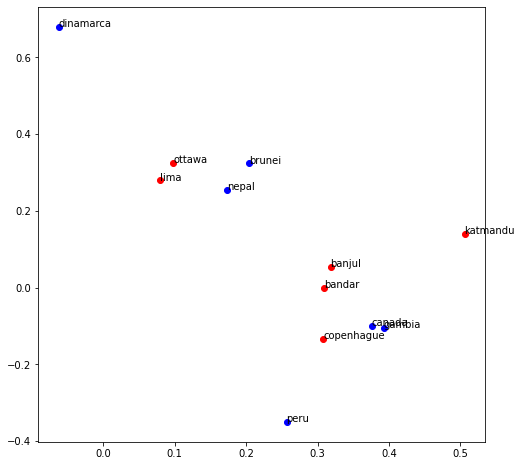

In [47]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes()

x = pca.components_[0,:]
y = pca.components_[1,:]

labels = ['peru','nepal','brunei','canada','dinamarca','gambia','lima','katmandu','bandar','ottawa','copenhague','banjul']

plt.scatter(x[0:6],y[0:6],color='b')
plt.scatter(x[6:],y[6:],color='r')

for label in range(12):
    ax.text(xdata[label],ydata[label],labels[label])

## 3D

In [17]:
# Aplicando PCA con 3 componentes
pca = PCA(n_components=3)
pca.fit(M.T)

print("Varianza explicada: ",pca.explained_variance_ratio_)

Varianza explicada:  [0.22434783 0.12191194 0.1189066 ]


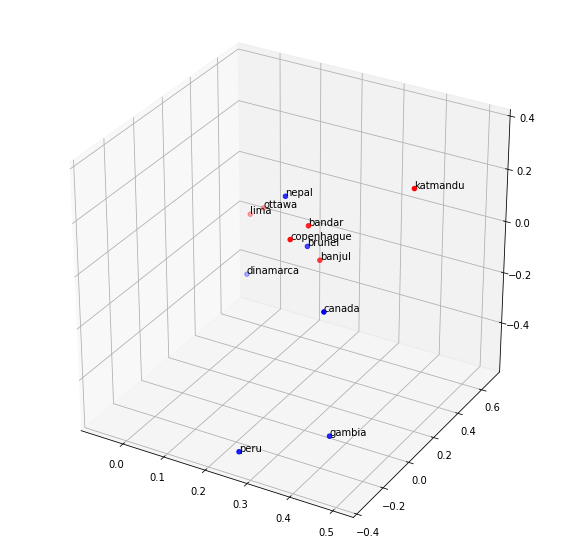

In [19]:
# Graficando las componentes de PCA
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')


labels = ['peru','nepal','brunei','canada','dinamarca','gambia','lima','katmandu','bandar','ottawa','copenhague','banjul']

# componentes de PCA
xdata = pca.components_[0,:]
ydata = pca.components_[1,:]
zdata = pca.components_[2,:]

ax.scatter3D(xdata[0:6], ydata[0:6], zdata[0:6],color='b')
ax.scatter3D(xdata[6:], ydata[6:], zdata[6:],color='r')

for label in range(12):
    ax.text(xdata[label],ydata[label],zdata[label],labels[label])

# Punto 6: Encontrando sinonimos

In [20]:
# Modelo con 4 divisiones y vectores de R^100
lsh = lshash.LSHash(4, 100)

for word in D:
    lsh.index(word)

In [21]:
# Palabras a buscar sinonimos
words = ['restos','mundo','antigua','comunidades','divide']

# Indices y vectores de las palabras
words_indx = [word_to_index[w] for w in words]
indx_vec = [D[i] for i in words_indx]

In [22]:
# Buscando las 10 palabras que mas se parecen
top = 10
for word in indx_vec:
    vecinos = lsh.query(word.tolist(),num_results=top,distance_func='cosine')
    print([index_to_word[getIndex(D,vecinos[i][0][0])] for i in range(len(vecinos))])

['restos', 'acumulacion', 'extensa', 'tratandose', 'longitud', 'comenzara', 'transformacion', 'dictadura', 'red', 'dominante']
['mundo', 'mismo', 'mayapajit', 'algodon', 'nivel', 'anchura', 'produccion', 'guano', 'intenso', 'maxima']
['antigua', 'ricas', 'extenso', 'rural', 'civilizacion', 'longitud', 'frescas', 'antiguas', 'quinta', 'popular']
['comunidades', 'algunas', 'benin', 'enfermedades', 'piezas', 'guerras', 'parlamentarias', 'lineas', 'venezuela', 'alrededor']
['divide', 'mantuvo', 'definieron', 'separados', 'libro', 'retiraron', 'organiza', 'aldea', 'articula', 'unieron']


# Punto 7 y 8: obteniendo corpus y representación de vectores

### Español

In [73]:
# Ejecución del código

fname = 'cuento.txt' #Nombre del archivo
C_E = 2 # Número de palabras de contexto a la derecha y a la izquierda
text_E = get_file_data(fname, stop_word_removal='no')
word_to_index_E,index_to_word_E,corpus_E,vocab_size_E,length_of_corpus_E = generate_dictinoary_data(text_E)
training_data_E,training_sample_words_E = generate_training_data(corpus_E,C_E,vocab_size_E,word_to_index_E,length_of_corpus_E,sample=None)

In [74]:
vocab_size_E

1027

In [75]:
# Definiendo red neuronal
model_E = Sequential()  
model_E.add(Dense(50,input_shape=(vocab_size_E,), activation='relu'))
model_E.add(Dense(vocab_size_E, activation='softmax'))

model_E.compile(loss='CategoricalCrossentropy', optimizer='rmsprop', metrics=['accuracy'])  

In [88]:
# Matriz de entrada y de salida
X_E = np.array([x[1] for x in training_data_E])
Y_E = np.array([y[0] for y in training_data_E])

X_train_E,X_test_E,Y_train_E,Y_test_E = train_test_split(X_E,Y_E,test_size=0.3)

# Entrenando
model_E.fit(X_train_E,Y_train_E,epochs=100,validation_data=(X_test_E,Y_test_E))

Epoch 1/100
53/53 [==============================] - 1s 11ms/step - loss: 4.0299 - accuracy: 0.7199 - val_loss: 4.1520 - val_accuracy: 0.7007
Epoch 2/100
53/53 [==============================] - 1s 10ms/step - loss: 3.7723 - accuracy: 0.7193 - val_loss: 4.0498 - val_accuracy: 0.7007
Epoch 3/100
53/53 [==============================] - 1s 9ms/step - loss: 3.5580 - accuracy: 0.7229 - val_loss: 3.9632 - val_accuracy: 0.7007
Epoch 4/100
53/53 [==============================] - 1s 10ms/step - loss: 3.3616 - accuracy: 0.7247 - val_loss: 3.8940 - val_accuracy: 0.7007
Epoch 5/100
53/53 [==============================] - 1s 10ms/step - loss: 3.1829 - accuracy: 0.7259 - val_loss: 3.8385 - val_accuracy: 0.7007
Epoch 6/100
53/53 [==============================] - 1s 19ms/step - loss: 3.0144 - accuracy: 0.7289 - val_loss: 3.7966 - val_accuracy: 0.6993
Epoch 7/100
53/53 [==============================] - 1s 27ms/step - loss: 2.8575 - accuracy: 0.7307 - val_loss: 3.7649 - val_accuracy: 0.7021
Epoch 8

53/53 [==============================] - 0s 8ms/step - loss: 0.0266 - accuracy: 0.9970 - val_loss: 4.9991 - val_accuracy: 0.4965
Epoch 59/100
53/53 [==============================] - 0s 9ms/step - loss: 0.0237 - accuracy: 0.9976 - val_loss: 5.0218 - val_accuracy: 0.4951
Epoch 60/100
53/53 [==============================] - 0s 9ms/step - loss: 0.0214 - accuracy: 0.9976 - val_loss: 5.0488 - val_accuracy: 0.4909
Epoch 61/100
53/53 [==============================] - 0s 9ms/step - loss: 0.0189 - accuracy: 0.9976 - val_loss: 5.0654 - val_accuracy: 0.4951
Epoch 62/100
53/53 [==============================] - 0s 9ms/step - loss: 0.0172 - accuracy: 0.9976 - val_loss: 5.0823 - val_accuracy: 0.4895
Epoch 63/100
53/53 [==============================] - 0s 9ms/step - loss: 0.0157 - accuracy: 0.9976 - val_loss: 5.1023 - val_accuracy: 0.4867
Epoch 64/100
53/53 [==============================] - 0s 9ms/step - loss: 0.0146 - accuracy: 0.9988 - val_loss: 5.1137 - val_accuracy: 0.4895
Epoch 65/100
53/53 

In [89]:
# Obteniendo representaciones de los vectores con las matrices de pesos
W1 = model_E.get_weights()[0]
W2 = model_E.get_weights()[2]
D_E = 0.5*(W2.T+W1)

### Ingles

In [78]:
fname = 'translate_f.txt' #Nombre del archivo
C_I = 2 # Número de palabras de contexto a la derecha y a la izquierda
text_I = get_file_data(fname, stop_word_removal='no')
word_to_index_I,index_to_word_I,corpus_I,vocab_size_I,length_of_corpus_I = generate_dictinoary_data(text_I)
training_data_I,training_sample_words_I = generate_training_data(corpus_I,C_I,vocab_size_I,word_to_index_I,length_of_corpus_I,sample=None)

In [79]:
vocab_size_I
len(corpus_I)

2615

In [80]:
len(corpus_E)

2382

In [86]:
# Definiendo red neuronal
model_I = Sequential()  
model_I.add(Dense(50,input_shape=(vocab_size_I,), activation='relu'))
model_I.add(Dense(vocab_size_I, activation='softmax'))

model_I.compile(loss='CategoricalCrossentropy', optimizer='rmsprop', metrics=['accuracy']) 

In [91]:
# Matriz de entrada y de salida
X_I = np.array([x[1] for x in training_data_I])
Y_I = np.array([y[0] for y in training_data_I])

X_train_I,X_test_I,Y_train_I,Y_test_I = train_test_split(X_I,Y_I,test_size=0.3)

# Entrenando
model_I.fit(X_train_I,Y_train_I,epochs=100,validation_data=(X_test_I,Y_test_I))

Epoch 1/100
58/58 [==============================] - 7s 114ms/step - loss: 6.6907 - accuracy: 0.0454 - val_loss: 6.5938 - val_accuracy: 0.0739
Epoch 2/100
58/58 [==============================] - 0s 5ms/step - loss: 6.3708 - accuracy: 0.0716 - val_loss: 6.2530 - val_accuracy: 0.0764
Epoch 3/100
58/58 [==============================] - 0s 5ms/step - loss: 5.9098 - accuracy: 0.0699 - val_loss: 6.0500 - val_accuracy: 0.0726
Epoch 4/100
58/58 [==============================] - 0s 5ms/step - loss: 5.6813 - accuracy: 0.0683 - val_loss: 6.0977 - val_accuracy: 0.0726
Epoch 5/100
58/58 [==============================] - 0s 5ms/step - loss: 5.5842 - accuracy: 0.0683 - val_loss: 6.1714 - val_accuracy: 0.0726
Epoch 6/100
58/58 [==============================] - 0s 4ms/step - loss: 5.5040 - accuracy: 0.0683 - val_loss: 6.2361 - val_accuracy: 0.0726
Epoch 7/100
58/58 [==============================] - 0s 5ms/step - loss: 5.4248 - accuracy: 0.0689 - val_loss: 6.2866 - val_accuracy: 0.0726
Epoch 8/100

Epoch 59/100
58/58 [==============================] - 0s 4ms/step - loss: 0.4161 - accuracy: 0.9475 - val_loss: 10.2355 - val_accuracy: 0.0790
Epoch 60/100
58/58 [==============================] - 0s 4ms/step - loss: 0.3911 - accuracy: 0.9454 - val_loss: 10.2981 - val_accuracy: 0.0815
Epoch 61/100
58/58 [==============================] - 0s 5ms/step - loss: 0.3672 - accuracy: 0.9552 - val_loss: 10.3529 - val_accuracy: 0.0790
Epoch 62/100
58/58 [==============================] - 0s 4ms/step - loss: 0.3442 - accuracy: 0.9568 - val_loss: 10.4118 - val_accuracy: 0.0790
Epoch 63/100
58/58 [==============================] - 0s 5ms/step - loss: 0.3240 - accuracy: 0.9623 - val_loss: 10.4672 - val_accuracy: 0.0803
Epoch 64/100
58/58 [==============================] - 0s 5ms/step - loss: 0.3043 - accuracy: 0.9628 - val_loss: 10.5399 - val_accuracy: 0.0803
Epoch 65/100
58/58 [==============================] - 0s 5ms/step - loss: 0.2859 - accuracy: 0.9639 - val_loss: 10.5979 - val_accuracy: 0.0790

In [92]:
# Obteniendo representaciones de los vectores con las matrices de pesos
W1 = model_I.get_weights()[0]
W2 = model_I.get_weights()[2]
D_I = 0.5*(W2.T+W1)

# Punto 9 : Obteniendo matriz de traducción R

In [162]:
for i in range(200,220):
    print(corpus_E[i],corpus_I[i])

la you
gente don
solo know
me anything
lee about
para video
decir games
sus this
amigos is
que an
soy ordeal
mejor people
que only
la read
pelicula me
realmente to
nadie tell
me their
entiende friends
ven that


### Traducción

In [204]:
X = ['consola','siempre','de','ser','sobre','estante','estupidos','ninos','comentarios','controles','sotano','su','madre','fracasados','son','idiotas','odio','creen','mas','que','cualquiera','creditos','saberse','juegos','quisiera','libro','ser','ellos','saben','como','viajando','padres','otro','creadores','respetados','genios','como','contar','pare','diferencia','solo','gorilas','corbatas','penetrantes','unicas','historias','excesivamente','filosofia','sonadores','diablos','circunspecto','responder','muy','voz','dijo','lee']
Y = ['console','always','of','being','on','shelf','stupid','children','comments','controls','basement','his','mother','losers','are','stupid','hate','believe','more','than','any','credits','knowing','games','would','book','be','they','know','how','traveling','parents','another','creative','respected','geniuses','as','counting','stop','unlike','only','gorillas','ties','penetrating','unique','stories','excessively','philosophy','dreamers','devils','circumspect','respond','very','voice','said','read']

In [205]:
# Indices de las palabras
X_indx = [word_to_index_E[w] for w in X]
Y_indx = [word_to_index_I[w] for w in Y]

# Vectores de las palabras
X_vec = np.array([D_E[i] for i in X_indx])
Y_vec = np.array([D_I[i]for i in Y_indx])

In [206]:
X_vec.shape

(56, 50)

In [207]:
# Matriz R
R = np.linalg.inv(X_vec.T@X_vec)@(X_vec.T@Y_vec)
print("Dimensiones de R: ",R.shape)

Dimensiones de R:  (50, 50)


# Punto 11 : Encontrando las 5 mejores traducciones

In [208]:
inx = 35 # Indice de la palabra a buscar del corpus en español
print("Palabra a traducir: ",index_to_word_E[inx])
I_word = D_E[inx]@R

Palabra a traducir:  unos


In [209]:
# Modelo con 4 divisiones de vecotres en R^30
lsh = lshash.LSHash(3, 50,num_hashtables=10)

for word in D_I:
    lsh.index(word)

In [210]:
# Buscando vecinos mas cercanos
top = 5
vecinos = lsh.query(I_word.tolist(),num_results=top,distance_func='cosine')
print([index_to_word_I[getIndex(D_I,vecinos[i][0][0])] for i in range(len(vecinos))])

['comments', 'blows', 'pedantic', 'more', 'stupid']


### Verificando con palabras de entrenamiento

In [213]:
count = 0
for i,d in enumerate(X):
    inx = word_to_index_E[d]
    I_word = D_E[inx]@R
    vecinos = lsh.query(I_word.tolist(),num_results=top,distance_func='cosine')
    b = [index_to_word_I[getIndex(D_I,vecinos[i][0][0])] for i in range(len(vecinos))]
    print(d,b)
    count+=1 if Y[i] in b else 0

consola ['console', 'game', 'video', 'shout', 'wish']
siempre ['always', 'hate', 'traveling', 'pass', 'they']
de ['of', 'marble', 'stairs', 'falling', 'instead']
ser ['stopped', 'souls', 'poking', 'fish', 'plumbers']
sobre ['on', 'eating', 'courtiers', 'settled', 'shelf']
estante ['shelf', 'knocked', 'carriage', 'neighboring', 'aleksei']
estupidos ['stupid', 'comments', 'disapproval', 'marble', 'stairs']
ninos ['children', 'spoiled', 'words', 'amazing', 'slobber']
comentarios ['comments', 'fat', 'stupid', 'marble', 'skating']
controles ['controls', 'life', 'neighboring', 'believed', 'sir']
sotano ['basement', 'mother', 'follow', 'these', 'his']
su ['his', 'follow', 'mother', 'saw', 'respond']
madre ['mother', 'basement', 'his', 'these', 'follow']
fracasados ['losers', 'these', 'believed', 'gregorio', 'demian']
son ['are', 'geniuses', 'hate', 'respected', 'willing']
idiotas ['stupid', 'comments', 'disapproval', 'marble', 'stairs']
odio ['hate', 'always', 'respected', 'are', 'they']
cree

In [214]:
count/len(X)

0.9642857142857143